In [1]:
import torch
import importlib
import callback, my_attn, my_pipeline, utils
importlib.reload(callback)
importlib.reload(my_attn)
importlib.reload(my_pipeline)
importlib.reload(utils)
from my_pipeline import run_with_attn_replacement, MutualAttention
from diffusers import StableDiffusionPipeline, DDIMInverseScheduler, DDIMScheduler
from my_attn import prep_unet_attention
from tqdm.notebook import tqdm
from callback import QKVRecordCallback
from utils import load_image, img_to_latents, concat_img 
from callback import ATTN_BLOCKS
from PIL import Image
import matplotlib.pyplot as plt
import os

2024-06-07 06:28:42.725619: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-07 06:28:42.766586: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-07 06:28:42.766658: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-07 06:28:42.767607: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-07 06:28:42.773996: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-07 06:28:42.774692: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
device = 'cuda'
dtype = torch.float16
sd15 = '/home/tom/fshare/models/runwayml/stable-diffusion-v1-5'
sd21 = '/home/tom/fshare/models/Stability-AI/stable-diffusion-2-1'

pipe = StableDiffusionPipeline.from_pretrained(
    sd15, safety_checker=None, torch_dtype=dtype)

pipe = pipe.to(device)
sampling_scheduler = pipe.scheduler
inverse_scheduler = DDIMInverseScheduler.from_pretrained(
        sd15, subfolder='scheduler')
ddim_scheduler = DDIMScheduler.from_pretrained(
        sd15, subfolder='scheduler')
negative_prompt = "longbody, lowres, bad anatomy, bad hands, missing fingers, extra digit, fewer digits, cropped, worst quality, low quality"

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


In [3]:
num_inversion_steps = 999
imgname = 'images/atri_canny.jpg'
input_img = load_image(
    imgname,
    target_size=(512, 512)
).to(device=device, dtype=dtype)
prompt_inversion = 'An anime girl, with background'

with torch.no_grad():
    pipe.scheduler = inverse_scheduler
    latents = img_to_latents(input_img, pipe.vae)  # VAE latent
    inv_latents, _ = pipe(
        prompt=prompt_inversion,
        guidance_scale=1,
        width=input_img.shape[-1],
        height=input_img.shape[-2],
        output_type='latent',
        return_dict=False,
        num_inference_steps=num_inversion_steps,
        latents=latents,
    )

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

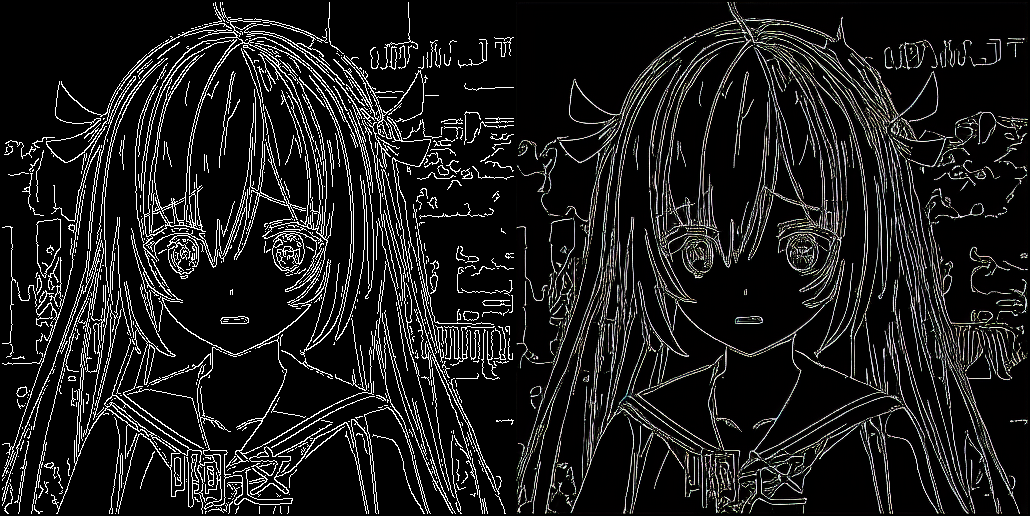

In [5]:
with torch.no_grad():
    pipe.scheduler = ddim_scheduler
    image = pipe(
        prompt=prompt_inversion,
        guidance_scale=1,
        num_inference_steps=100,
        latents=inv_latents,
        output_type='pt',
    ).images[0]
concat_img([input_img, image.unsqueeze(0)])

In [8]:
new_latents = torch.randn_like(inv_latents)

  0%|          | 0/100 [00:00<?, ?it/s]

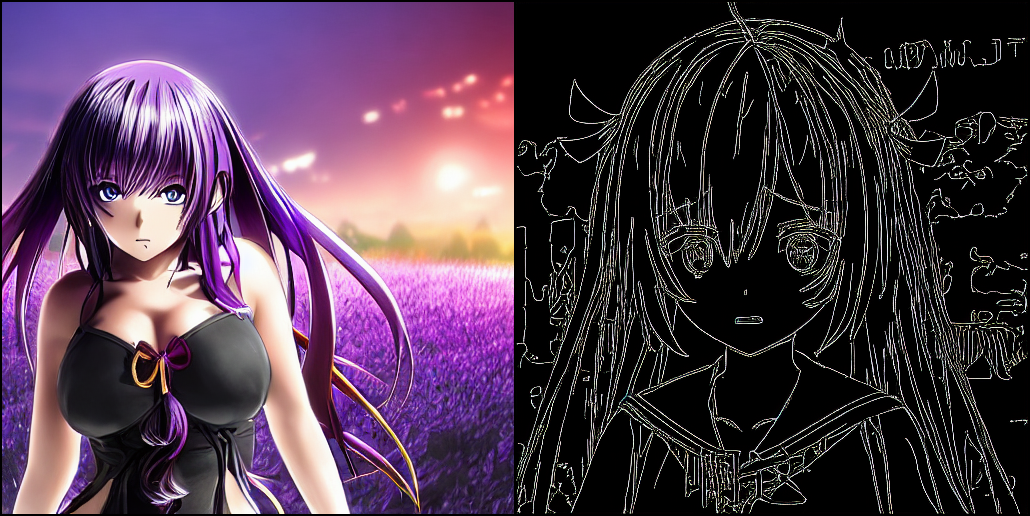

In [28]:
pipe.scheduler = sampling_scheduler
mutual_attn = MutualAttention(pipe, ddim_scheduler)
with torch.no_grad():
    result = mutual_attn(
        replaced_attn_indice=[1,3, 7, 9, 11, 13, 15,17],
        replaced_qkv=['q', 'k'],
        end=700,
        prompt='An anime girl, with background, purple hair',
        negative_prompt=negative_prompt,
        ref_prompt='An anime girl, with background',
        latents=new_latents,
        ref_latents=inv_latents,
        guidance_scale=9,
        num_inference_steps=100
    )
concat_img(list(result))

  0%|          | 0/50 [00:00<?, ?it/s]

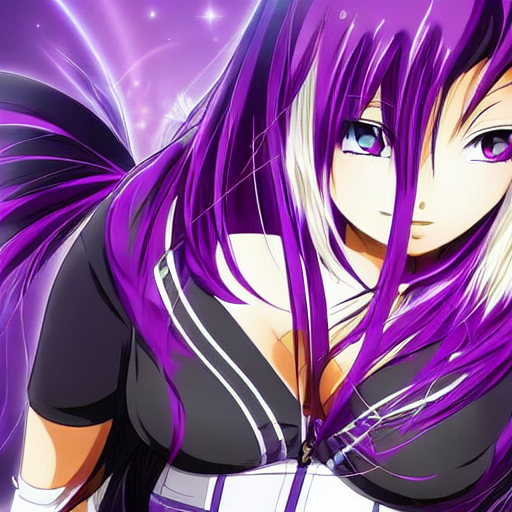

In [27]:
image = pipe(
    'An anime girl, with background, purple hair', 
    negative_prompt=negative_prompt, 
    latents=new_latents,
    num_inference_steps=50,
)
image.images[0]

In [35]:
mutual_attn = MutualAttention(pipe)
pipe.scheduler = DDIMScheduler.from_pretrained(
        '/home/tom/fshare/models/Stability-AI/stable-diffusion-2-1', subfolder='scheduler')
replaced_qkv_list = [
    ['none'],
    ['q'],
    ['k'],
    ['v'],
    ['q','k'],
    ['q','v'],
    ['k','v'],
    ['q','k','v'],
]
attn_indice_list = [
    [10, 12, 13, 11],
    [10, 12, 13, 11, 30],
    [10, 12, 13, 11, 31],
    [10, 12, 13, 11, 30, 31],
]
with torch.no_grad():
    for attn_indice in attn_indice_list:
        for replaced_qkv in replaced_qkv_list:
            result = mutual_attn(
                replaced_attn_indice=attn_indice,
                replaced_qkv=replaced_qkv,
                end=500,
                prompt='A monkey is sitting in a basket on a branch',
                ref_prompt='A kitten is sitting in a basket on a branch',
                latents=new_latent,
                ref_latents=inv_latents,
            )
            img = concat_img(list(result))
            # create folder if not exist
            os.makedirs(f"results/{'_'.join([str(_) for _ in attn_indice])}", exist_ok=True)
            img.save(f"results/{'_'.join([str(_) for _ in attn_indice])}/{''.join(replaced_qkv)}.jpg")

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]